In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as tfs

from matplotlib.colors import ListedColormap

import os
import pandas as pd
from torchvision.io import read_image
from pathlib import Path
import imagesize
from dataclasses import dataclass
from PIL import Image
from torchvision.transforms import ToTensor
from functools import lru_cache
from datetime import datetime
import time
from itertools import islice
from os import listdir
from os.path import isfile, join
from matplotlib.pyplot import text
import random

In [2]:
from dataset import *
from utils import *

In [3]:
start = time.time()


max_size=(512, 512)
batch_size=8

print('Using max_size =', max_size)

unsupervised_train_dataset = InriaImageDataset("/home/s0011/_scratch/ekb", img_dir="images", label_dir="gt", max_size=max_size, load=False, debug=False, crop_tensor=False)
unsupervised_train_dataloader = DataLoader(unsupervised_train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

unlabeled_dataset = InriaImageDataset("/home/s0011/_scratch/ekb", img_dir="unlabeled", label_dir="", max_size=max_size, load=False, debug=False, crop_tensor=False, labeled=False)
unlabeled_dataloader = DataLoader(unsupervised_train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

end = time.time()
print("Preparing time", end - start)

Using max_size = (512, 512)
Preparing dataset in /home/s0011/_scratch/ekb
Images directory /home/s0011/_scratch/ekb/images
Labels directory /home/s0011/_scratch/ekb/gt
Total images = 1
Total crops = 42
Preparing dataset in /home/s0011/_scratch/ekb
Images directory /home/s0011/_scratch/ekb/unlabeled
Labels directory /home/s0011/_scratch/ekb
Total images = 12
Total crops = 88
Preparing time 2.666445732116699


Dataset size = 88


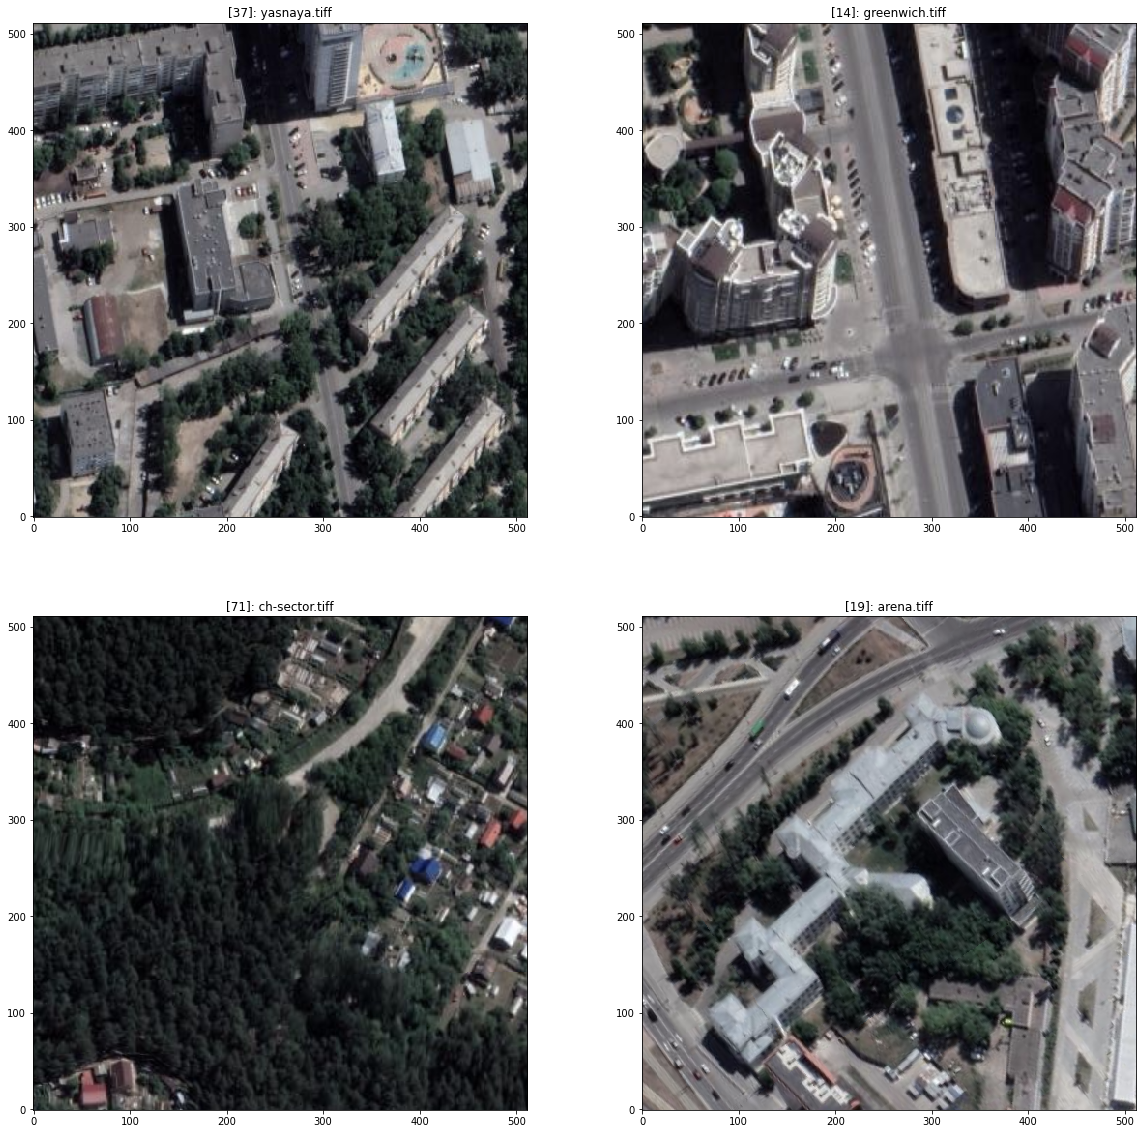

In [4]:
dataset_samples(unlabeled_dataset)

In [6]:
!ls saves/*

'saves/before_ekb_try_2022-04-03_19:44:43.267771':

'saves/before_ekb_try_2022-04-03_21:11:57.494569':
 final.pth			   'model-epoch1-train1800|1823.pth'
'model-epoch1-train1000|1823.pth'  'model-epoch1-train200|1823.pth'
'model-epoch1-train100|1823.pth'   'model-epoch1-train300|1823.pth'
'model-epoch1-train1100|1823.pth'  'model-epoch1-train400|1823.pth'
'model-epoch1-train1200|1823.pth'  'model-epoch1-train500|1823.pth'
'model-epoch1-train1300|1823.pth'  'model-epoch1-train600|1823.pth'
'model-epoch1-train1400|1823.pth'  'model-epoch1-train700|1823.pth'
'model-epoch1-train1500|1823.pth'  'model-epoch1-train800|1823.pth'
'model-epoch1-train1600|1823.pth'  'model-epoch1-train900|1823.pth'
'model-epoch1-train1700|1823.pth'

'saves/first_try_2022-03-31_01:41:57.134129':

'saves/first_try_2022-03-31_01:50:55.493841':
'model-epoch1-train1000|1823.pth'  'model-epoch1-train1800|1823.pth'
'model-epoch1-train100|1823.pth'   'model-epoch1-train200|1823.pth'
'model-epoch1-train1100|1823.pth'  'mo

In [8]:
saves_path = Path("/misc/home1/s0011/segmentim/saves")

In [9]:
import segmentation_models_pytorch as smp

get_model = lambda: smp.Unet(
    encoder_name="efficientnet-b0",
#     encoder_weights="imagenet",
    encoder_depth = 3,
#     encoder_weights = None,
#     decoder_use_batchnorm: bool = True,
    decoder_channels = (64, 32, 16),
    in_channels=3,
    classes=1,
)
model = get_model()
criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
model_path = saves_path / 'second_net_2022-04-04_02:22:43.603496' / 'final.pth'
model = get_model()
criterion = IoULoss()
optimizer = torch.optim.Adam(model.parameters())

checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

teacher_model_path = saves_path / 'fix_val_net_2022-04-05_02:14:30.627808' / 'final-epoch4.pth'
teacher_model = get_model()
checkpoint = torch.load(model_path)
teacher_model.load_state_dict(checkpoint['model_state_dict'])
teacher_model.eval()
print()

In [17]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
device = 'cpu'
print(device)
model.to(device)

cpu


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [ ]:
session_prefix = "semi_supervised"

train_dataloader = unlabeled_dataloader
validation_dataloader = unsupervised_train_dataloader

date = str(datetime.now()).replace(" ", "_")
model_dir = saves_path / f"{session_prefix}_{date}"
os.mkdir(model_dir)

n_epochs = 50
save_every = 100
val_every = 1
total_data = len(train_dataloader)

end = 0
losses = {}
ious = {}
val_ious = {}
val_losses = {}

begin_time = time.time()
total_data = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    losses[epoch] = []
    ious[epoch] = []
    val_ious[epoch] = []
    val_losses[epoch] = []
    data_n = 0    
    for images, _ in train_dataloader:
        model.train()
        start = time.time()
        print('Iteration time', start - end)
        
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        with torch.no_grad():
            pseudo_labels = teacher_model(images)
        loss = criterion(outputs, pseudo_labels)
        loss.backward()
        optimizer.step()

        losses[epoch].append(loss.item())
        train_loss += loss.item()
        
        ious[epoch].append(1 - loss.item())
        print('Epoch: {} {}\nLoss {:.6f}'.format(epoch, data_n, loss))
        
        end = time.time()
        print("Batch time", end - start, '\n')
        data_n += 1
        if data_n % save_every == 0:
            model_path = model_dir/f"model-epoch{epoch}-train{data_n}|{total_data}.pth"
            print('Saving into', model_path)
            save(model, optimizer, model_path, epoch, loss, time.time() - begin_time, losses, ious, val_ious, val_losses)
        if data_n >= total_data:
            model_path = model_dir/f"final-epoch{epoch}.pth"
            print('Saving into', model_path)
            save(model, optimizer, model_path, epoch, loss, time.time() - begin_time, losses, ious, val_ious, val_losses)

        if data_n % val_every == 0 or data_n >= total_data:
            for test_images, test_labels in validation_dataloader:
                model.eval()
                with torch.no_grad():
                    out = model(test_images)
                    out = torch.sigmoid(out)
                    val_loss = criterion(out, test_labels)
                    val_ious[epoch].append((data_n, 1-val_loss.item()))
                    val_losses[epoch].append((data_n, val_loss.item()))
                    print('Val IoU', 1- val_loss.item())
                break
        
    train_loss = train_loss/len(train_dataloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Iteration time 1649191708.384358
Epoch: 1 0
Loss 0.428038
Batch time 13.493346929550171 

Val IoU 0.28581178188323975
Iteration time 10.03849172592163
Epoch: 1 1
Loss 0.715658
Batch time 14.03017520904541 

Val IoU 0.10313421487808228
Iteration time 10.015909671783447
Epoch: 1 2
Loss 0.452499
Batch time 13.17735242843628 

